In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO(conv_num=1):
    init_channel = 64
    
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=init_channel, strides=1, padding='same', 
                      activation='relu', input_shape=input_shape)) 
#     model.add(BatchNormalization())
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=int(init_channel*(2**int((i+1)/3))), 
                          strides=1, padding='same', activation='relu'))
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 16,384,400
Trainable params: 16,384,400
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (ty

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 1777, 64)          0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 1777, 128)         41088     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 592, 128)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0167 - acc: 0.3569
Epoch 00001: val_loss improved from inf to 1.52417, saving model to model/checkpoint/1D_CNN_custom_3_DO_4_conv_checkpoint/001-1.5242.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 2.0165 - acc: 0.3570 - val_loss: 1.5242 - val_acc: 0.5111
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4278 - acc: 0.5559
Epoch 00002: val_loss improved from 1.52417 to 1.29778, saving model to model/checkpoint/1D_CNN_custom_3_DO_4_conv_checkpoint/002-1.2978.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 1.4279 - acc: 0.5559 - val_loss: 1.2978 - val_acc: 0.6122
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2201 - acc: 0.6260
Epoch 00003: val_loss improved from 1.29778 to 1.21699, saving model to model/c

36800/36805 [============================>.] - ETA: 0s - loss: 0.0933 - acc: 0.9723
Epoch 00027: val_loss did not improve from 1.02295
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0933 - acc: 0.9723 - val_loss: 1.4205 - val_acc: 0.7060
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0890 - acc: 0.9744
Epoch 00028: val_loss did not improve from 1.02295
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0890 - acc: 0.9744 - val_loss: 1.5740 - val_acc: 0.7030
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0838 - acc: 0.9761
Epoch 00029: val_loss did not improve from 1.02295
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0838 - acc: 0.9761 - val_loss: 1.5098 - val_acc: 0.7086
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0819 - acc: 0.9767
Epoch 00030: val_loss did not improve from 1.02295
36805/36805 [========================

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0444 - acc: 0.9873
Epoch 00057: val_loss did not improve from 1.02295
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0444 - acc: 0.9873 - val_loss: 1.6437 - val_acc: 0.7393

1D_CNN_custom_3_DO_4_conv Model


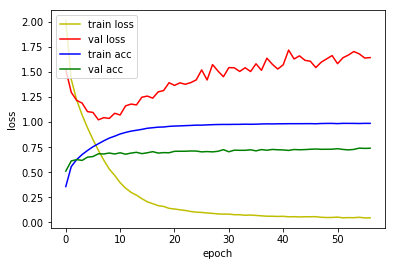

4815/4815 [==============================] - 3s 606us/sample - loss: 1.1352 - acc: 0.6540
Loss: 1.135193683920372 Accuracy: 0.6539979

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0823 - acc: 0.3193
Epoch 00001: val_loss improved from inf to 1.51416, saving model to model/checkpoint/1D_CNN_custom_3_DO_5_conv_checkpoint/001-1.5142.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 2.0823 - acc: 0.3192 - val_loss: 1.5142 - val_acc: 0.5141
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4505 - acc: 0.5389
Epoch 00002: val_loss improved from 1.51416 to 1.21992, saving model to model/checkpoint/1D_CNN_custom_3_DO_5_conv_checkpoint/002-1.2199.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.4505 - acc: 0.5389 - val_loss: 1.2199 - val_acc: 0.6385
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2108 - acc:

36800/36805 [============================>.] - ETA: 0s - loss: 0.2237 - acc: 0.9284
Epoch 00025: val_loss did not improve from 0.68907
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.2237 - acc: 0.9284 - val_loss: 0.7345 - val_acc: 0.8141
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2172 - acc: 0.9321
Epoch 00026: val_loss did not improve from 0.68907
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.2172 - acc: 0.9322 - val_loss: 0.8412 - val_acc: 0.8020
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2030 - acc: 0.9357
Epoch 00027: val_loss did not improve from 0.68907
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.2029 - acc: 0.9357 - val_loss: 0.7562 - val_acc: 0.8153
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1935 - acc: 0.9389
Epoch 00028: val_loss did not improve from 0.68907
36805/36805 [========================

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0890 - acc: 0.9736
Epoch 00055: val_loss did not improve from 0.68907
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0890 - acc: 0.9736 - val_loss: 0.8908 - val_acc: 0.8288
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0801 - acc: 0.9765
Epoch 00056: val_loss did not improve from 0.68907
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0801 - acc: 0.9765 - val_loss: 0.9094 - val_acc: 0.8269
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0867 - acc: 0.9747
Epoch 00057: val_loss did not improve from 0.68907
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0867 - acc: 0.9747 - val_loss: 0.8793 - val_acc: 0.8295
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0830 - acc: 0.9752
Epoch 00058: val_loss did not improve from 0.68907
36805/36805 [===========

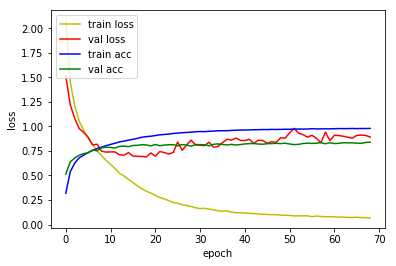

4815/4815 [==============================] - 3s 609us/sample - loss: 0.8078 - acc: 0.7724
Loss: 0.8077790394255182 Accuracy: 0.77237797

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2170 - acc: 0.2759
Epoch 00001: val_loss improved from inf to 1.51771, saving model to model/checkpoint/1D_CNN_custom_3_DO_6_conv_checkpoint/001-1.5177.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 2.2169 - acc: 0.2760 - val_loss: 1.5177 - val_acc: 0.5181
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5067 - acc: 0.5093
Epoch 00002: val_loss improved from 1.51771 to 1.29293, saving model to model/checkpoint/1D_CNN_custom_3_DO_6_conv_checkpoint/002-1.2929.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 1.5067 - acc: 0.5093 - val_loss: 1.2929 - val_acc: 0.5968
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3147 - ac

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2850 - acc: 0.9132
Epoch 00025: val_loss did not improve from 0.37374
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.2849 - acc: 0.9132 - val_loss: 0.3756 - val_acc: 0.8975
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2731 - acc: 0.9156
Epoch 00026: val_loss improved from 0.37374 to 0.36877, saving model to model/checkpoint/1D_CNN_custom_3_DO_6_conv_checkpoint/026-0.3688.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.2731 - acc: 0.9156 - val_loss: 0.3688 - val_acc: 0.9029
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2583 - acc: 0.9200
Epoch 00027: val_loss did not improve from 0.36877
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.2584 - acc: 0.9200 - val_loss: 0.4427 - val_acc: 0.8866
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.251

36800/36805 [============================>.] - ETA: 0s - loss: 0.1081 - acc: 0.9642
Epoch 00054: val_loss did not improve from 0.36047
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.1081 - acc: 0.9642 - val_loss: 0.3770 - val_acc: 0.9201
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1101 - acc: 0.9636
Epoch 00055: val_loss did not improve from 0.36047
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.1101 - acc: 0.9636 - val_loss: 0.3945 - val_acc: 0.9168
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1030 - acc: 0.9663
Epoch 00056: val_loss did not improve from 0.36047
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.1030 - acc: 0.9663 - val_loss: 0.4108 - val_acc: 0.9115
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1027 - acc: 0.9665
Epoch 00057: val_loss did not improve from 0.36047
36805/36805 [========================

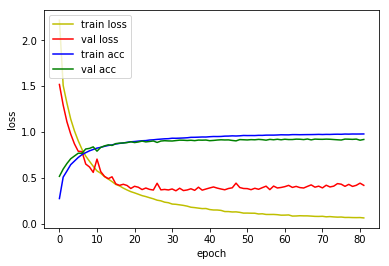

4815/4815 [==============================] - 3s 619us/sample - loss: 0.4158 - acc: 0.8862
Loss: 0.4157717520202803 Accuracy: 0.886189

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2056 - acc: 0.2735
Epoch 00001: val_loss improved from inf to 1.49116, saving model to model/checkpoint/1D_CNN_custom_3_DO_7_conv_checkpoint/001-1.4912.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 2.2055 - acc: 0.2735 - val_loss: 1.4912 - val_acc: 0.5278
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4092 - acc: 0.5402
Epoch 00002: val_loss improved from 1.49116 to 1.07226, saving model to model/checkpoint/1D_CNN_custom_3_DO_7_conv_checkpoint/002-1.0723.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 1.4092 - acc: 0.5402 - val_loss: 1.0723 - val_acc: 0.6744
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1277 - acc:

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1766 - acc: 0.9422
Epoch 00025: val_loss did not improve from 0.21584
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.1766 - acc: 0.9422 - val_loss: 0.2307 - val_acc: 0.9376
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1650 - acc: 0.9463
Epoch 00026: val_loss did not improve from 0.21584
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.1650 - acc: 0.9463 - val_loss: 0.2237 - val_acc: 0.9369
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1597 - acc: 0.9468
Epoch 00027: val_loss did not improve from 0.21584
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.1597 - acc: 0.9469 - val_loss: 0.2219 - val_acc: 0.9362
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1547 - acc: 0.9486
Epoch 00028: val_loss did not improve from 0.21584
36805/36805 [===========

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0683 - acc: 0.9771
Epoch 00054: val_loss did not improve from 0.18216
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.0683 - acc: 0.9771 - val_loss: 0.2096 - val_acc: 0.9532
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0598 - acc: 0.9789
Epoch 00055: val_loss did not improve from 0.18216
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0598 - acc: 0.9789 - val_loss: 0.1955 - val_acc: 0.9515
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0599 - acc: 0.9795
Epoch 00056: val_loss did not improve from 0.18216
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0599 - acc: 0.9795 - val_loss: 0.2157 - val_acc: 0.9490
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0608 - acc: 0.9788
Epoch 00057: val_loss did not improve from 0.18216
36805/36805 [===========

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0349 - acc: 0.9879
Epoch 00084: val_loss did not improve from 0.18216
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.0349 - acc: 0.9879 - val_loss: 0.2210 - val_acc: 0.9553
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0326 - acc: 0.9893
Epoch 00085: val_loss did not improve from 0.18216
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0326 - acc: 0.9893 - val_loss: 0.2399 - val_acc: 0.9555
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0365 - acc: 0.9874
Epoch 00086: val_loss did not improve from 0.18216
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.0364 - acc: 0.9874 - val_loss: 0.2273 - val_acc: 0.9543
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0345 - acc: 0.9876
Epoch 00087: val_loss did not improve from 0.18216
36805/36805 [===========

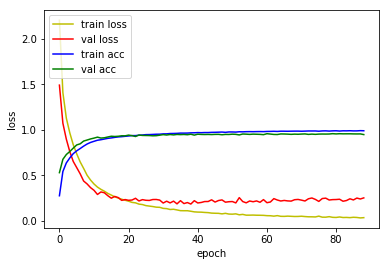

4815/4815 [==============================] - 3s 628us/sample - loss: 0.2246 - acc: 0.9327
Loss: 0.224630900942029 Accuracy: 0.9327103

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0712 - acc: 0.3266
Epoch 00001: val_loss improved from inf to 1.17092, saving model to model/checkpoint/1D_CNN_custom_3_DO_8_conv_checkpoint/001-1.1709.hdf5
36805/36805 [==============================] - 58s 2ms/sample - loss: 2.0711 - acc: 0.3267 - val_loss: 1.1709 - val_acc: 0.6436
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1199 - acc: 0.6351
Epoch 00002: val_loss improved from 1.17092 to 0.74508, saving model to model/checkpoint/1D_CNN_custom_3_DO_8_conv_checkpoint/002-0.7451.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 1.1199 - acc: 0.6350 - val_loss: 0.7451 - val_acc: 0.7654
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8231 - acc:

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1192 - acc: 0.9607
Epoch 00025: val_loss did not improve from 0.13247
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.1192 - acc: 0.9607 - val_loss: 0.1452 - val_acc: 0.9541
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1136 - acc: 0.9621
Epoch 00026: val_loss improved from 0.13247 to 0.12061, saving model to model/checkpoint/1D_CNN_custom_3_DO_8_conv_checkpoint/026-0.1206.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.1136 - acc: 0.9622 - val_loss: 0.1206 - val_acc: 0.9623
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1068 - acc: 0.9656
Epoch 00027: val_loss did not improve from 0.12061
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.1068 - acc: 0.9656 - val_loss: 0.1271 - val_acc: 0.9613
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.097

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0407 - acc: 0.9867
Epoch 00055: val_loss did not improve from 0.12061
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0407 - acc: 0.9867 - val_loss: 0.1279 - val_acc: 0.9669
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0409 - acc: 0.9852
Epoch 00056: val_loss did not improve from 0.12061
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0409 - acc: 0.9852 - val_loss: 0.1487 - val_acc: 0.9653
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0359 - acc: 0.9876
Epoch 00057: val_loss did not improve from 0.12061
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0360 - acc: 0.9875 - val_loss: 0.1361 - val_acc: 0.9679
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0374 - acc: 0.9871
Epoch 00058: val_loss did not improve from 0.12061
36805/36805 [===========

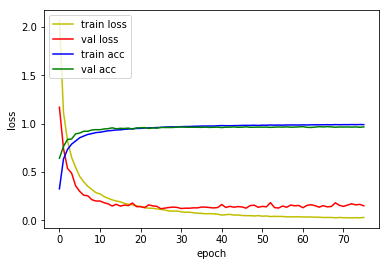

4815/4815 [==============================] - 3s 652us/sample - loss: 0.1654 - acc: 0.9470
Loss: 0.16538701458589433 Accuracy: 0.9470405

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8831 - acc: 0.3923
Epoch 00001: val_loss improved from inf to 0.90783, saving model to model/checkpoint/1D_CNN_custom_3_DO_9_conv_checkpoint/001-0.9078.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 1.8832 - acc: 0.3922 - val_loss: 0.9078 - val_acc: 0.7135
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8713 - acc: 0.7207
Epoch 00002: val_loss improved from 0.90783 to 0.58937, saving model to model/checkpoint/1D_CNN_custom_3_DO_9_conv_checkpoint/002-0.5894.hdf5
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.8713 - acc: 0.7207 - val_loss: 0.5894 - val_acc: 0.8157
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6064 - ac

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0713 - acc: 0.9758
Epoch 00026: val_loss did not improve from 0.12694
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0713 - acc: 0.9758 - val_loss: 0.1428 - val_acc: 0.9604
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0684 - acc: 0.9766
Epoch 00027: val_loss did not improve from 0.12694
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0684 - acc: 0.9766 - val_loss: 0.1627 - val_acc: 0.9543
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0647 - acc: 0.9779
Epoch 00028: val_loss did not improve from 0.12694
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0648 - acc: 0.9779 - val_loss: 0.1457 - val_acc: 0.9604
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0649 - acc: 0.9779
Epoch 00029: val_loss did not improve from 0.12694
36805/36805 [===========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0237 - acc: 0.9925
Epoch 00056: val_loss did not improve from 0.12694
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0237 - acc: 0.9925 - val_loss: 0.1847 - val_acc: 0.9616
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0256 - acc: 0.9920
Epoch 00057: val_loss did not improve from 0.12694
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0256 - acc: 0.9920 - val_loss: 0.1537 - val_acc: 0.9634
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0227 - acc: 0.9928
Epoch 00058: val_loss did not improve from 0.12694
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0227 - acc: 0.9928 - val_loss: 0.1876 - val_acc: 0.9644
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0239 - acc: 0.9922
Epoch 00059: val_loss did not improve from 0.12694
36805/36805 [===========

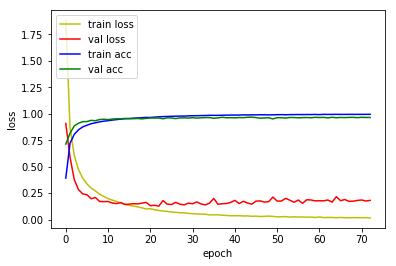

4815/4815 [==============================] - 3s 685us/sample - loss: 0.1985 - acc: 0.9402
Loss: 0.19848673819861185 Accuracy: 0.9401869



In [10]:
for i in range(4, 10):
    base = '1D_CNN_custom_3_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_3_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(4, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_3_DO_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 1777, 64)          0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 1777, 128)         41088     
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 592, 12

4815/4815 [==============================] - 3s 670us/sample - loss: 0.2246 - acc: 0.9327
Loss: 0.224630900942029 Accuracy: 0.9327103

1D_CNN_custom_3_DO_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_67 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
max_pooling1d_54 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
max_pooling1d_55 (MaxPooling (None, 1777, 64)          0         
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 1777,

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(4, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_3_DO_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 1777, 64)          0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 1777, 128)         41088     
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 592, 12

4815/4815 [==============================] - 4s 730us/sample - loss: 0.3232 - acc: 0.9323
Loss: 0.32320576873825535 Accuracy: 0.9322949

1D_CNN_custom_3_DO_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_67 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
max_pooling1d_54 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
max_pooling1d_55 (MaxPooling (None, 1777, 64)          0         
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 177